## 非结构化网格数据可视化

* 非结构化网格数据读写库列举：

    - [meshio](https://github.com/nschloe/meshio)

    - [h5](https://docs.h5py.org/en/latest/build.html)

* Matplotlib 的非结构化网格数据可视化函数

    - `triplot`, `tricontour`, `tricontourf`, `tripcolor`
    
    **注意**：这几个函数只支持三角网格数据

In [1]:
import pandas as pd
import numpy as np
from matplotlib.ticker import MultipleLocator
import matplotlib as mpl
mpl.rcParams["font.family"] = 'Arial'  #默认字体类型
mpl.rcParams["mathtext.fontset"] = 'cm' #数学文字字体
mpl.rcParams["contour.negative_linestyle"] = 'dashed'  #默认字体类型
import matplotlib.pyplot as plt
import os
from netCDF4 import Dataset
# 新增
import meshio 
import h5py
import scipy.interpolate

### 非结构化网格数据读取

In [2]:
mesh=meshio.read('Data/UnstructuredGrid/porous1.vtu')
print(mesh)

<meshio mesh object>
  Number of points: 20606
  Number of cells:
    triangle: 41292
  Point data: RegionId
  Cell data: RegionId


In [3]:
x,y,z=mesh.points[:,0],mesh.points[:,1],mesh.points[:,2]
triangles=mesh.cells[0].data
pointdata=mesh.point_data['RegionId']
celldata=mesh.cell_data['RegionId'][0]

### 1. 案例一： Digital rock slice

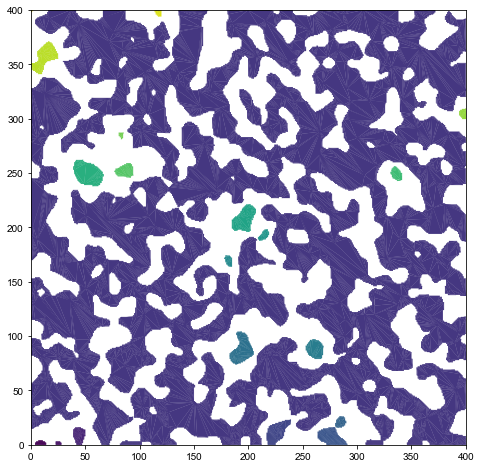

In [4]:
fig=plt.figure(figsize=(8,8))
ax=plt.gca()
ax.axis('scaled')

# 分离出z=z0的某个面上的网格
z1_triangles,z2_triangles,z3_triangles=z[triangles[:,0]],z[triangles[:,1]],z[triangles[:,2]]
z0=np.min(z)
ind_triangles_z0=((z1_triangles==z0) & (z2_triangles==z0) &(z3_triangles==z0))

# ax.triplot(x,y,triangles[ind_triangles_z0],lw=0.1)
# ax.tricontourf(x,y,triangles[ind_triangles_z0],pointdata,cmap='rainbow')
# ax.tripcolor(x,y,triangles[ind_triangles_z0],pointdata,cmap='rainbow',edgecolor='face')  # 划重点： edgecolor='face' 避免出现白色的“幽灵线条”
ax.tripcolor(x,y,triangles[ind_triangles_z0,:],facecolors=celldata[ind_triangles_z0],edgecolor='face')

ax.set_xlim(np.min(x),np.max(x))
ax.set_ylim(np.min(y),np.max(y))
fname_fig='../../figures/Chapter3/Lecture3_2_example1.pdf'
fig.savefig(fname_fig)
os.system('pdfcrop '+fname_fig+' '+fname_fig)

plt.show()

## 案例2：非结构化三角网物理场可视化

- 数据来源于论文：[10.1029/2019JB019035](https://doi.org/10.1029/2019JB019035)

- 数据下载链接：[figshare](https://figshare.com/articles/dataset/All_data_files_and_processing_script_of_Anhydrite-assisted_hydrothermal_metal_transport_to_the_ocean_floor_insights_from_thermo-hydro-chemical_modeling_/10347839)

- 数据格式：hdf5

In [5]:
meshfile='Data/UnstructuredGrid/XDMF/MESH.h5'
fieldfile='Data/UnstructuredGrid/XDMF/Data_06000.h5'
MESH=h5py.File(meshfile,'r')
VAR=h5py.File(fieldfile,'r')
print(MESH.keys(),VAR.keys())

<KeysViewHDF5 ['BoundaryPolygon_ptID', 'EL2NOD', 'GCOORD', 'PhaseID', 'PointID']> <KeysViewHDF5 ['Cca', 'Cso4', 'Kr', 'P', 'Perm', 'Perm_log', 'Rho_f', 'S_CaSO4', 'S_FeS2', 'T', 'Vx', 'Vz']>


In [10]:
# get points coordinate and triangles
GCOORD=MESH['GCOORD'][:]
x=GCOORD[:,0]
y=GCOORD[:,1]
triangles=MESH['EL2NOD'][:]
triangles=triangles.reshape(-1,4)
triangles=triangles[:,1:4]
phaseID=MESH['PhaseID'][:]-1
phaseID_unique=np.unique(phaseID)
print('The mesh contains',len(phaseID_unique),'regions')


The mesh contains 2 regions


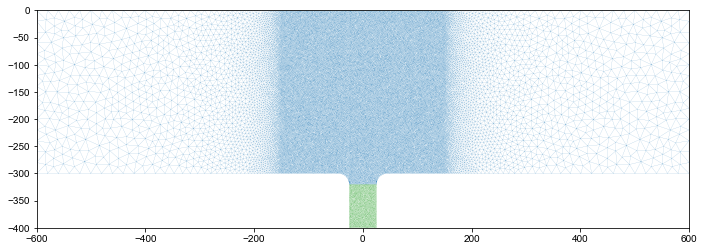

In [8]:
# plot
fig=plt.figure(figsize=(12,4))
ax=fig.gca()
ax.axis('scaled')
ax.set_xlim(np.min(x),np.max(x))
ax.set_ylim(np.min(y),np.max(y))

# 1. plot mesh
for phaseid in phaseID_unique:
    ax.triplot(x,y,triangles[phaseID==phaseid],lw=0.1)
fname_fig='../../figures/Chapter3/Lecture3_2_example2_mesh.pdf'

fig.savefig(fname_fig)
os.system('pdfcrop '+fname_fig+' '+fname_fig)

plt.show()

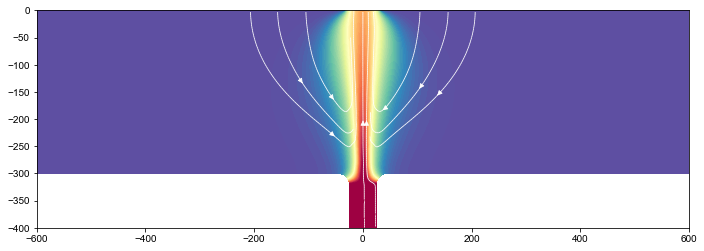

In [20]:
# plot
fig=plt.figure(figsize=(12,4))
ax=fig.gca()
ax.axis('scaled')
ax.set_xlim(np.min(x),np.max(x))
ax.set_ylim(np.min(y),np.max(y))

# get field
# fields_name=list(VAR.keys())
fieldname='T'
var=VAR[fieldname][:]

# 2. plot field contour
CS=ax.tricontourf(x,y,triangles,var,cmap='Spectral_r',levels=100,extend='both')
# ax.tricontour(x,y,triangles,var,linewidths=1)
# for a in CS.collections:
#     a.set_edgecolor('face')
#     a.set_linewidth(0.00)

# 3. 流场图
vx=VAR['Vx'][:]
vy=VAR['Vz'][:]
v_norm = np.sqrt(vx**2 + vy**2)
# 3.1 quiver
# ax.quiver(x, y, vx/v_norm, vy/v_norm,
#           scale=100., zorder=3, color='blue',
#           width=0.004, headwidth=3., headlength=10.)
# 3.2 stream plot: interpolate to a structured grid first
YY,XX = np.mgrid[np.min(y):np.max(y):200j,np.min(x):np.max(x):200j]
VX = scipy.interpolate.griddata((x,y), vx, (XX.reshape(-1,), YY.reshape(-1,)), method='cubic').ravel()
VY = scipy.interpolate.griddata((x,y), vy, (XX.reshape(-1,), YY.reshape(-1,)), method='cubic').ravel()
VX,VY=VX.reshape(XX.shape),VY.reshape(XX.shape)
seed_x=[-200,-150, -100,-10,10, 0, 100,150, 200]
seed_points = np.array([seed_x, np.zeros_like(seed_x)-50])
ax.streamplot(XX,YY, VX,VY,density=[4, 2],linewidth=0.8,color='w',start_points=seed_points.T)

# axis lim
ax.set_xlim(np.min(x),np.max(x))
ax.set_ylim(np.min(y),np.max(y))

fname_fig=str('../../figures/Chapter3/Lecture3_2_example2_%s.pdf'%(fieldname))
fig.savefig(fname_fig)
os.system('pdfcrop '+fname_fig+' '+fname_fig)

plt.show()